# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4653,9444,54396,Deal: Kent,19-03-2020,Minnesota has now classified grocery store wor...,Negative
14594,21533,66485,"Torrance, CA",23-03-2020,"As news of #covid19 continues to spread, much ...",Positive
6445,11631,56583,Behind You,19-03-2020,My daughter works for @sobeys and had this hap...,Extremely Positive
20359,28635,73587,NaN,27-03-2020,The high demand for eggs in the United States ...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'].unique() #Всего 4 класса

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [4]:
#Заменим Positive/Extremely Positive на 1, а Extremely Negative/Negative - на 0
df['Sentiment'].replace({'Positive': 1, 'Extremely Positive': 1, 'Extremely Negative': 0, 'Negative':0}, inplace=True)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
33428,44934,89886,"New York, NY",14-04-2020,"As physical stores close, clothing retailers a...",1
23379,32361,77313,Tokyo,04-04-2020,Coronavirus upends global food supply chains i...,0
19943,28112,73064,NaN,26-03-2020,A customer returned a Zipsak to @biaggiluggage...,1
660,4585,49537,"Denver, Colorado",17-03-2020,The line to the grocery store was around the b...,0


In [5]:
df['Sentiment'].unique() #Получилось!

array([1, 0], dtype=int64)

Сбалансированы ли классы?

In [6]:
n_positive = df[df['Sentiment']==1].shape[0]
n_negative = df[df['Sentiment']==0].shape[0]
n_all = df['Sentiment'].count()
print(f"Класс позитивных твиттов: {n_positive} шт ({round(100*n_positive/n_all)} %)")
print(f"Класс негативных твиттов: {n_negative} шт ({round(100*n_negative/n_all)} %)")

Класс позитивных твиттов: 18046 шт (54 %)
Класс негативных твиттов: 15398 шт (46 %)


**Ответ:** Классы можно считать сбалансированыными, слишком большого перевеса нет, но все же позитивныз твиттов больше.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
df.isnull().any().any() #True - нужно поработать с пропусками

True

In [8]:
df.info() #Проблемы в Location

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [9]:
#Заменяем пропуски на 'Unknown'
df.fillna('Unknown', inplace=True)

#Проверка на пропуски
df.isnull().any().any() #Победа!

False

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split

col_list = list(df)
col_list.remove('Sentiment')
#Делим на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(df[col_list], df['Sentiment'], test_size=0.3, shuffle=True, random_state=66)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [11]:
texts = list(X_train['OriginalTweet'])
texts_tokenized = []
for t in texts:
    texts_tokenized += [w.lower() for w in t.split(' ') ] 

In [12]:
from collections import Counter
cnt = Counter(texts_tokenized) #Счетчик словаря

Какой размер словаря получился?

In [13]:
print(f'Размер словаря токенов: {len(cnt)}')

Размер словаря токенов: 85156


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [14]:
cnt.most_common(10)

[('the', 26652),
 ('to', 23331),
 ('and', 14400),
 ('of', 12945),
 ('a', 11616),
 ('in', 11185),
 ('for', 8553),
 ('', 7472),
 ('is', 7442),
 ('#coronavirus', 7157)]

**Ответ:** Словарь получился из 85156 уникальных токенов. 10 самых популярных токенов не несут смысла, т.к. являются артиклями, предлогам, союзами и формами глагола to be

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [15]:
import nltk
nltk.download("stopwords", quiet=True)

True

In [16]:
import nltk
from nltk.corpus import stopwords

In [17]:
stop_words = stopwords.words('english')
filtered_texts = [word for word in texts_tokenized if word not in stop_words]

In [18]:
cnt = Counter(filtered_texts)
print(f'Размер словаря токенов: {len(cnt)}, самые популярные токены:')
print(*cnt.most_common(10))

Размер словаря токенов: 84985, самые популярные токены:
('', 7472) ('#coronavirus', 7157) ('prices', 3852) ('food', 3740) ('grocery', 3394) ('supermarket', 3258) ('people', 3096) ('store', 3094) ('covid-19', 3087) ('consumer', 2263)


**Ответ:**  Словарь уменьшился на 171 токенов (это меньше 1% от размера словаря). Но зато популярные токены обрели смысл, теперь это в основном существительные.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [19]:
print('Непопулярные токены')
print(*(cnt.most_common()[-1:-21:-1]))

Непопулярные токены
('#travelinn', 1) ('#asthma', 1) ('exercise-induced', 1) ('https://t.co/wsakq6lbsd', 1) ('car.\r\r\n#humanity\r\r\n#coronavirus', 1) ('heart.\r\r\nwe', 1) ('melt', 1) ('gestures', 1) ('gifted', 1) ('strike.', 1) ('amazon/wal', 1) ('charmin?', 1) ('deplete', 1) ('sure...but', 1) ('elan', 1) ('verification', 1) ('workflow', 1) ('composition', 1) ('https://t.co/d541rwgp9e', 1) ('combatting', 1)


**Ответ:** Скорее всего, эти токены непопулярны по нескольким причинам: первая - это редко встречающееся слово, вторая - слова находятся не в нормальной форме (множественное число, проведшее время, опечатки), третья - токен является не словом, а ссылкой/хэштегом/непонятно чем. Нужно почистить пунктуацию, убрать ссылки, убрать переводы строк. А еще нужна бы лемматизация!



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [20]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
texts_tw = []
for t in texts:
    texts_tw += [w.lower() for w in tw.tokenize(t)]

In [21]:
cnt = Counter(texts_tw)
print(f'Размер словаря токенов: {len(cnt)}, самые популярные токены:')
print(*cnt.most_common(10))

Размер словаря токенов: 58861, самые популярные токены:
('the', 27023) ('.', 23953) ('to', 23464) (',', 17558) ('and', 14624) ('of', 12979) ('a', 11807) ('in', 11393) ('?', 9809) ('#coronavirus', 8847)


**Ответ:** Размер словаря значительно уменьшился. TweetTokenizer - токенизатор с поддержкой особенностей коротких сообщений, поэтому топ отличается. В топе оказались знаки препинания, союзы, предлоги и артикли, а также хештег.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [22]:
from string import punctuation
noise = stopwords.words("english") + list(punctuation)
filtered_texts = [word for word in texts_tw if word not in noise]

In [23]:
cnt = Counter(filtered_texts)
print(f'Размер словаря токенов: {len(cnt)}, самые популярные токены:')
print(*cnt.most_common(10))

Размер словаря токенов: 58658, самые популярные токены:
('#coronavirus', 8847) ('â', 7461) ('\x82', 7358) ('19', 7091) ('covid', 6173) ('prices', 4637) ('\x92', 4389) ('food', 4314) ('supermarket', 3855) ('store', 3807)


**Ответ:** После удаления стоп-слов и пунктуации в топе, кроме понятных хештега и существительных, оказались довольно странные символы. Возможно, они появились из-за разных кодировок/языков/символов у авторов твиттов.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [24]:
abs_filtered_texts = [word for word in filtered_texts if not (len(word) == 1 and ord(word) >= 128)]

In [25]:
cnt = Counter(abs_filtered_texts)
print(f'Размер словаря токенов: {len(cnt)}, самые популярные токены:')
print(*cnt.most_common(10))

Размер словаря токенов: 58617, самые популярные токены:
('#coronavirus', 8847) ('19', 7091) ('covid', 6173) ('prices', 4637) ('food', 4314) ('supermarket', 3855) ('store', 3807) ('grocery', 3489) ('people', 3424) ('#covid19', 2607)


In [26]:
print('Непопулярные токены')
print(*(cnt.most_common()[-1:-21:-1]))

Непопулярные токены
('#travelinn', 1) ('#asthma', 1) ('exercise-induced', 1) ('https://t.co/wsakq6lbsd', 1) ('melt', 1) ('gestures', 1) ('deplete', 1) ('elan', 1) ('verification', 1) ('composition', 1) ('https://t.co/d541rwgp9e', 1) ('combatting', 1) ('https://t.co/kgadj29pos', 1) ('syndicates', 1) ('#peterdutton', 1) ('https://t.co/jnfaj5380w', 1) ('telescope', 1) ('#karenrebels', 1) ('https://t.co/0kpkats9kp', 1) ('1.18', 1)


**Ответ:** Размер словаря (по сравнению с токенизацией по пробелам) значительно уменьшился. А в топе у части токенов увеличилась встречаемость, например:'#coronavirus', 7157 -> 8847; 'prices', 3852 -> 4637.  

Сам же топ тоже немного изменился. Например, из топа выпало 'covid-19', но появились '19' и 'covid' (кажется, что это не совсем удобно, т.к. по сути covid-19 - это один термин). Также пропал самый популярный токен '', что несомненно является плюсом,т.к. он не нес смысла. Поэтому вывод - есть плюсы, а есть и минусы. Как посмотреть.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [27]:
hashtags = [word for word in filtered_texts if len(word)>1 and word[0] == '#']

In [28]:
cnt_hash = Counter(hashtags)
print(f'Размер словаря токенов: {len(cnt_hash)}, самые популярные токены:')
print(*cnt_hash.most_common(10))

Размер словаря токенов: 9956, самые популярные токены:
('#coronavirus', 8847) ('#covid19', 2607) ('#covid_19', 1784) ('#covid2019', 965) ('#toiletpaper', 737) ('#covid', 657) ('#socialdistancing', 488) ('#coronacrisis', 434) ('#pandemic', 256) ('#stayhome', 233)


**Ответ:** Большинство топовых хештегов связаны с тематикой ковида, #coronavirus  имеет значительное преимущество в частоте перед остальными. Всего зафиксировано почти 10к хештегов.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [29]:
s = 't.co'
links = [word for word in filtered_texts if s in word]

In [30]:
cnt_link = Counter(links)
print(f'Размер словаря токенов: {len(cnt_link)}, самые популярные токены:')
print(*cnt_link.most_common(10))

Размер словаря токенов: 12872, самые популярные токены:
('https://t.co/g63rp042ho', 5) ('https://t.co/3kfuiojxep', 4) ('https://t.co/wrlhyzizaa', 4) ('https://t.co/oi39zsanq8', 4) ('https://t.co/wuieefsnoj', 3) ('https://t.co/hpo7uwkakl', 3) ('https://t.co/6yvykiab2c', 3) ('https://t.co/xpcm2xkj4o', 3) ('https://t.co/oxa7swtond', 3) ('https://t.co/gp3eusapl8', 3)


**Ответ:** Количество уникальных ссылок больше, чем хештегов. Но при этом самая топовая ссылка встречается только 5 раз. Это значит, что для нас нет смысла анализировать ссылки, а вот хештеги есть.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [31]:
def custom_tokenizer(text):
    tokens = [w.lower() for w in tw.tokenize(text)]
    tokens = [word for word in tokens if word not in noise and 
                      not (len(word) == 1 and ord(word) >= 128) and s not in word]
    
    
    return tokens


In [32]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [34]:
texts_tokenized = []
for t in texts:
    texts_tokenized += custom_tokenizer(t)
X = cv.fit_transform(texts_tokenized)

print(len(cv.vocabulary_))

40270


**Ответ:** Изначальный словарь был около 85к, новый же словарь 40к - очень значительное уменьшение количества уникальных токенов.

Посмотрим на какой-нибудь конкретный твитт:

In [35]:
ind = 9024
x_test = X_train.iloc[ind]['OriginalTweet']
X_train.iloc[ind]['OriginalTweet'], y_train.iloc[ind]

('@JacksonLeeTX18 Trump hopes sanctions+Covid-19 kill enough Iranians weaken govt to force regime change Such murderous policy strengthen Iranians&amp;govt Its New Year celebration weathers US perfect storm of sanctions low oil prices Covid-19 Resulting hum',
 0)

Автор твитта не доволен политикой Трампа, текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [36]:
len(custom_tokenizer(x_test))

34

In [37]:
bow  = cv.transform(custom_tokenizer(x_test))

In [38]:
bow.toarray().shape

(34, 40270)

In [39]:
dd = pd.DataFrame(bow .toarray(), columns=cv.get_feature_names_out())

In [40]:
dd.shape #размер матрицы

(34, 40270)

In [41]:
sum_list = []
for col in list(dd):
    if  dd[col]. sum () > 0:
        sum_list.append((col, dd[col]. sum ())) #считаем суммы столбцов, чтобы найти популярный и непопулярный токен
sum_list = sorted(sum_list, key = lambda x: x[1], reverse = True)
print(f'Самый важный токен: {sum_list[0]}')
print(f'Самый неважный токен: {sum_list[-1]}')

Самый важный токен: ('19', 2)
Самый неважный токен: ('year', 1)


**Ответ:** Самым важным оказался токен '19', но он встречается всего 2 раза, против непопулярного с частотой 1. Сликшом маленький текст для анализа. Но для определения окраса текста эти токены не помогают.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(texts_tokenized)
print(len(cv.vocabulary_)) #Размер словаря такой же, все ок

40270


In [43]:
transformed  = tfidf_vec.transform(custom_tokenizer(x_test))

In [44]:
df_tf = pd.DataFrame(transformed[0].T.todense(),index=tfidf_vec.get_feature_names_out(), columns=["TF-IDF"])
df_tf = df_tf.sort_values('TF-IDF', ascending=False)
#Идея сортировки отсюда: https://habr.com/ru/articles/778048/
print(df_tf)

                TF-IDF
jacksonleetx18     1.0
00                 0.0
pce                0.0
pbs                0.0
pbump              0.0
...                ...
external           0.0
externaldata       0.0
externalities      0.0
extinct            0.0
âºper              0.0

[40270 rows x 1 columns]


**Ответ:** Самым важным токеном оказался 'jacksonleetx18', т.е. логин другого пользователя. Непонятно, почему этот токен важен

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [45]:
X_train[X_train['OriginalTweet'].apply(lambda x: 'love' in x) & (y_train == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet
9261,15037,59989,Europe,20-03-2020,From with love and respect for those taking ca...
31175,42149,87101,Hellhaim,11-04-2020,"I love that supermarket staff, during this Cov..."
1737,5918,50870,Unknown,17-03-2020,@PrimetimeJermyn Hi Jermyn. We follow the Food...
549,4456,49408,Unknown,17-03-2020,Relax stay calm the majority of cases are mild...
18120,25849,70801,Norfolk,25-03-2020,Britain is a nation of reality TV lovers give ...
...,...,...,...,...,...
20533,28851,73803,England,29-03-2020,I went to the supermarket after a week at home...
31758,42870,87822,"Warrington, England",12-04-2020,"One day weÃÂll go back in the car, weÃÂll ..."
25809,35411,80363,Unknown,07-04-2020,Protect what you love
31746,42855,87807,"Anambra, Nigeria",12-04-2020,Onitsha social media foundation sensitized Oni...


In [46]:
x_test = X_train['OriginalTweet'][9261]
x_test # хороший позитивный твитт

'From with love and respect for those taking care of us doctors teachers cleaners transport sector supermarket workers nurses logisticians ambulance ppl fire ppl police etc'

In [47]:
transformed  = tfidf_vec.transform(custom_tokenizer(x_test))

In [48]:
df_tf = pd.DataFrame(transformed[0].T.todense(),index=tfidf_vec.get_feature_names_out(), columns=["TF-IDF"])
df_tf = df_tf.sort_values('TF-IDF', ascending=False)
print(df_tf)

                 TF-IDF
love                1.0
pchidambaram_in     0.0
pbump               0.0
pc                  0.0
pc19                0.0
...                 ...
external            0.0
externaldata        0.0
externalities       0.0
extinct             0.0
âºper               0.0

[40270 rows x 1 columns]


**Ответ:** 'love' выделился как самый важный токен, этот токен действительно помогает понять окрас твитта)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler

In [50]:
from sklearn.metrics import classification_report, roc_auc_score

In [51]:
#TF-EDF
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_train = tfidf_vec.fit_transform(X_train['OriginalTweet'])
tfidf_test = tfidf_vec.transform(X_test['OriginalTweet'])

scaler = MaxAbsScaler()
tfidf_train = scaler.fit_transform(tfidf_train)
tfidf_test = scaler.transform(tfidf_test)

In [52]:
#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(tfidf_train, y_train)
pred_tfidf = clf.predict(tfidf_test)

In [53]:
print(accuracy_score(y_test, pred_tfidf), '- accuracy с TF-EDF на тестовых')
print(accuracy_score(y_train, clf.predict(tfidf_train)), '- accuracy с TF-EDF на обучающих')

0.860075742475583 - accuracy с TF-EDF на тестовых
0.9833404527979496 - accuracy с TF-EDF на обучающих


In [54]:
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4703
           1       0.86      0.88      0.87      5331

    accuracy                           0.86     10034
   macro avg       0.86      0.86      0.86     10034
weighted avg       0.86      0.86      0.86     10034



In [55]:
#CountVectorizer
cv = CountVectorizer(tokenizer=custom_tokenizer)
cv_train = cv.fit_transform(X_train['OriginalTweet'])
cv_test = cv.transform(X_test['OriginalTweet'])

scaler = MaxAbsScaler()
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

In [56]:
#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(cv_train, y_train)
pred_cv = clf.predict(cv_test)

In [57]:
print(accuracy_score(y_test, pred_cv), '- accuracy с CountVectorizer на тестовых')
print(accuracy_score(y_train, clf.predict(cv_train)), '- accuracy с CountVectorizer на обучающих')

0.8638628662547339 - accuracy с CountVectorizer на тестовых
0.9829560017086715 - accuracy с CountVectorizer на обучающих


In [58]:
print(classification_report(y_test, pred_cv))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4703
           1       0.86      0.88      0.87      5331

    accuracy                           0.86     10034
   macro avg       0.86      0.86      0.86     10034
weighted avg       0.86      0.86      0.86     10034



Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

**Ответ:** И там, и там получились хорошие результаты, причем примерно одинаковые. Нет кого-то сильно лучше.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [59]:
from nltk.stem.snowball import SnowballStemmer

In [60]:
def custom_stem_tokenizer(text):
    text_tokenized = custom_tokenizer(text)
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(w) for w in text_tokenized]
    
    return tokens

In [61]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [62]:
#CountVectorizer
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_train = cv.fit_transform(X_train['OriginalTweet'])
print(len(cv.vocabulary_))

37128


In [63]:
#TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_train = tfidf_vec.fit_transform(X_train['OriginalTweet'])
print(len(tfidf_vec.vocabulary_))

37128


**Ответ** Размер словаря был 40к, а стал 37к, т.е. примерно на 3к уменьшился. Это ощутимый вклад.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [64]:
#CountVectorizer
cv_test = cv.transform(X_test['OriginalTweet'])

scaler = MaxAbsScaler()
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(cv_train, y_train)
pred_cv = clf.predict(cv_test)

print(accuracy_score(y_test, pred_cv), '- accuracy с CountVectorizer на тестовых')
print(accuracy_score(y_train, clf.predict(cv_train)), '- accuracy с CountVectorizer на обучающих')

0.8594777755630855 - accuracy с CountVectorizer на тестовых
0.9706535668517727 - accuracy с CountVectorizer на обучающих


In [65]:
#TfidfVectorizer
tfidf_train = tfidf_vec.fit_transform(X_train['OriginalTweet'])
tfidf_test = tfidf_vec.transform(X_test['OriginalTweet'])

scaler = MaxAbsScaler()
tfidf_train = scaler.fit_transform(tfidf_train)
tfidf_test = scaler.transform(tfidf_test)

#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(tfidf_train, y_train)
pred_tfidf = clf.predict(tfidf_test)

print(accuracy_score(y_test, pred_tfidf), '- accuracy с TF-EDF на тестовых')
print(accuracy_score(y_train, clf.predict(tfidf_train)), '- accuracy с TF-EDF на обучающих')

0.8593781144110025 - accuracy с TF-EDF на тестовых
0.9709098675779582 - accuracy с TF-EDF на обучающих


**Ответ:** Со стеммингом результаты так же получились примерные одинаковые. Но у каждой модели результаты чуть хуже, чем без стемминга

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет **37127** (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [66]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000# -- YOUR CODE HERE --
                        ).fit(
                            X_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

C:\Users\79633\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


37127


**Ответ:** Вспомним, что самый топовый токен был со встречаемостью около 8,8к, а следующий токен имел встречаемсоть уже около 2к. Поэтому ограничение max_df в промежутке между первыми по встречаемости токенами даст уменьшение словаря на 1.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [67]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(X_train['OriginalTweet'])
print(len(cv.vocabulary_))

37128


In [68]:
#Со скалированием MaxAbsScaler
cv_train = cv_df.transform(X_train['OriginalTweet'])
cv_test = cv_df.transform(X_test['OriginalTweet'])

scaler = MaxAbsScaler()
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(cv_train, y_train)
pred_cv = clf.predict(cv_test)

print(accuracy_score(y_test, pred_cv), '- accuracy с CountVectorizer на тестовых')
print(accuracy_score(y_train, clf.predict(cv_train)), '- accuracy с CountVectorizer на обучающих')

0.863763205102651 - accuracy с CountVectorizer на тестовых
0.9164886800512602 - accuracy с CountVectorizer на обучающих


In [69]:
#Без скалирования
cv_train = cv_df.transform(X_train['OriginalTweet'])
cv_test = cv_df.transform(X_test['OriginalTweet'])

#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(cv_train, y_train)
pred_cv = clf.predict(cv_test)

print(accuracy_score(y_test, pred_cv), '- accuracy с CountVectorizer на тестовых')
print(accuracy_score(y_train, clf.predict(cv_train)), '- accuracy с CountVectorizer на обучающих')

0.8655571058401436 - accuracy с CountVectorizer на тестовых
0.9282357966680905 - accuracy с CountVectorizer на обучающих


**Ответ:** Если сравнивать accuracy (со скалированием) для двух моделей, где применяем min_df в векторайзере и нет. То значение на тестовых данных при применении немного выросло с 0.8595 до 0.8638, а на обучающих данных упало с 0.9706 до 0.9165. 

min_df точно очень полезный показатель, т.к. при уменьшении словаря в 10 раз, метрики остались хорошими.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [70]:
from sklearn.preprocessing import StandardScaler
#Ой, а я уже скалировала MaxAbsScaler в других заданиях, но теперь сделаю с StandardScaler
scaler = StandardScaler(with_mean=False)
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(cv_train, y_train)
pred_cv = clf.predict(cv_test)

print(accuracy_score(y_test, pred_cv), '- accuracy с CountVectorizer на тестовых')
print(accuracy_score(y_train, clf.predict(cv_train)), '- accuracy с CountVectorizer на обучающих')

0.8437313135339845 - accuracy с CountVectorizer на тестовых
0.9403246475865015 - accuracy с CountVectorizer на обучающих


In [71]:
len(clf.coef_[0])

3700

In [72]:
len(cv_df.get_feature_names_out())

3700

In [73]:
print('Признак с самым большим коэффициентом: ', cv_df.get_feature_names_out()[np.argmax(clf.coef_)])
print('Признак с самым наименьшим коэффициентом: ', cv_df.get_feature_names_out()[np.argmin(clf.coef_)])

Признак с самым большим коэффициентом:  hand
Признак с самым наименьшим коэффициентом:  crisi


In [74]:
coef_list = list(zip(cv_df.get_feature_names_out(),clf.coef_[0]))
coef_list = sorted(coef_list, key = lambda x: abs(x[1]), reverse = True)[:10]
coef_list

[('crisi', -1.7695623319740168),
 ('panic', -1.3189489031412316),
 ('hand', 1.156909203437494),
 ('help', 1.0327563012596126),
 ('best', 0.985280036805027),
 ('free', 0.9662217386023916),
 ('thank', 0.9652782871378502),
 ('like', 0.9279388733821814),
 ('safe', 0.925606129529099),
 ('scam', -0.880662035389115)]

<AxesSubplot:title={'center':'Top-10 tokens with weights'}, xlabel='token', ylabel='weight'>

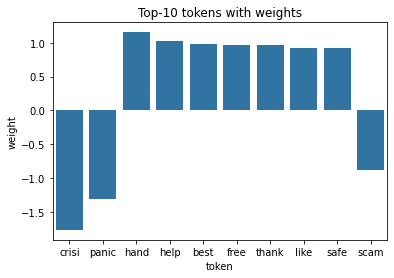

In [75]:
df_barplot = pd.DataFrame(coef_list, columns=['token', 'weight'])
plt.title("Top-10 tokens with weights")
sns.barplot(df_barplot, x='token', y='weight')

**Ответ:** (по сравнению с моделью без скалирования) accuracy на трейне выросло, но на тесте упало:(

Самые влиятельные токены представлены на графике выше, например: crisi, panic имеют сильное отрицательное влияние, а hand, help - положительное.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

<AxesSubplot:title={'center':'Correlations between features and Sentiment - target'}>

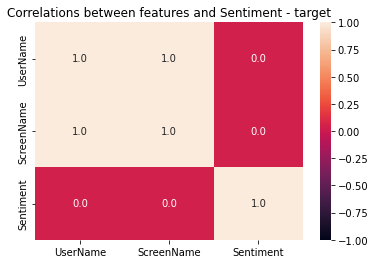

In [76]:
df = pd.merge(X_train[['UserName', 'ScreenName']], y_train, left_index=True, right_index=True)
plt.title("Correlations between features and Sentiment - target")
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt=".1f")

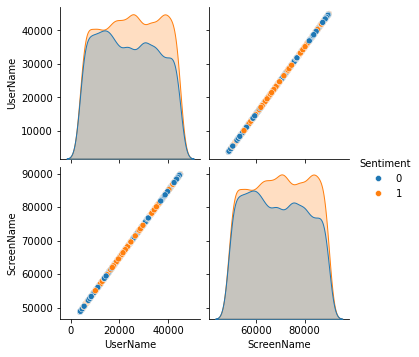

In [77]:
sns.pairplot(df, hue="Sentiment")

**Ответ:** Связи между признаками UserName, ScreenName и Sentiment не обнаружено. В модель эти признаки добавлять нет смысла.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [78]:
from datetime import datetime, date, time

In [79]:
X_train['TweetAt']=X_train['TweetAt'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))

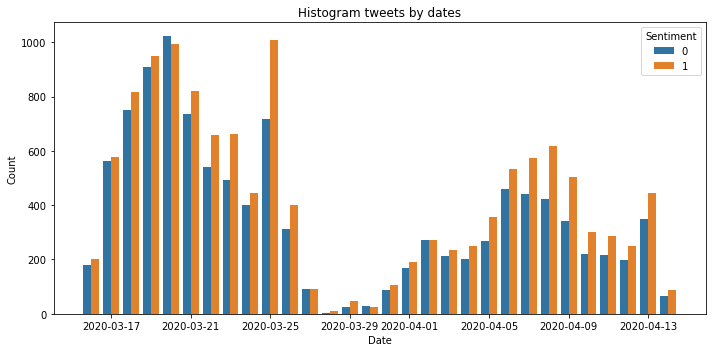

In [80]:
df_hist = pd.merge(y_train, X_train['TweetAt'], left_index=True, right_index=True)

#Гистрограмма через барплот
plt.figure(figsize=(10, 5))
plt.title("Histogram tweets by dates")
ax1 = sns.barplot(
    df_hist, x='TweetAt', y = 'Sentiment',
    native_scale=True,
    estimator="count", errorbar=None, hue = 'Sentiment'
)

plt.ylabel("Count")
plt.xlabel("Date")
plt.legend(title='Sentiment')
plt.tight_layout()

**Ответ:** Зависимости времени твитта от таргета нет. Смысла добавлять в модель этот признак нет.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [81]:
X_train['Location'].nunique() #Количество уникальных значений

7882

In [82]:
X_train['Location'].value_counts().head(10) #Самые популярные значения

Unknown            4926
London, England     298
London              291
United States       291
Washington, DC      227
New York, NY        216
United Kingdom      194
Los Angeles, CA     160
India               157
UK                  141
Name: Location, dtype: int64

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

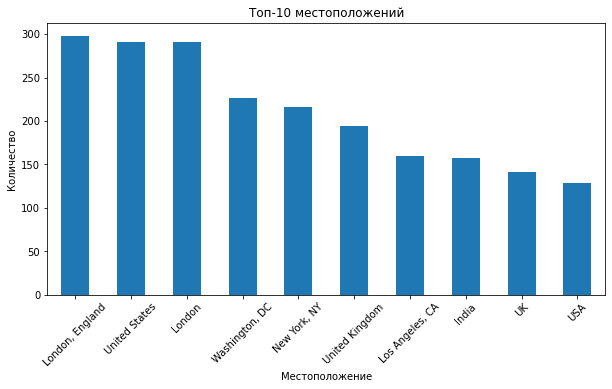

In [83]:
top_locations = X_train['Location'][X_train['Location'] != 'Unknown'].value_counts().head(10)

# Построение гистограммы
plt.figure(figsize=(10, 5))
plt.title("Barplot of tweets locations")
top_locations.plot(kind='bar')

plt.title('Топ-10 местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [84]:
def splitting(x): #для деления строки
    if ',' in x:
        y = x.split(',')[1]
        if len(y) > 0 and y[0] == ' ':
            return y[1:]
        return y
    return x 

def set_wider_location(x): #соответствие стране
    if 'London' in x or 'England' in x or 'UK' in x or 'United Kingdom' in x or 'U.K.' in x:
        return 'UK'
    elif 'USA' in x or 'United States' in x or 'New York' in x or 'Los Angeles' in x or 'Chicago' in x or 'San Francisco' in x  or 'Atlanta' in x or 'Boston' in x or 'California' in x or 'Florida' in x or 'Texas' in x or 'Washington' in x:
        return 'USA'
    elif 'India' in x or 'New Delhi' in x:
        return 'India'
    elif 'Toronto' in x or 'Canada' in x or 'Ontario' in x:
        return 'Canada'
    elif 'New South Wales' in x or 'NSW' in x or 'Australia' in x:
        return 'Australia'
    
    else:
        #сокращения США
        for t in ['US', 'LA', 'KY', 'KS', 'IA', 'IN', 'IL', 'ID', 'HI', 'GA', 'FL', 'DC', 'DE', 'CT', 'CO', 'CA', 'AR', 'AZ', 'АК', 'AL', 'OR', 'ОК', 'OH', 'ND', 'NC', 'NY', 'NM', 'NJ', 'NH', 'NV', 'NE', 'MT', 'MO', 'MS', 'MN', 'MI', 'MA', 'MD', 'ME', 'WY', 'WI', 'WV', 'WA', 'VA', 'VT', 'UT', 'TX', 'TN', 'SD', 'SC', 'PA', 'RI']:
            if t in x:
                return 'USA'
        x = splitting(x)
        return x


In [85]:
X_train['WiderLocation'] = X_train['Location'].apply(set_wider_location)
X_test['WiderLocation'] = X_test['Location'].apply(set_wider_location)
X_train['WiderLocation'].nunique() #количество уникальных широких локаций

3562

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [86]:
from sklearn.preprocessing import OneHotEncoder

In [87]:
X_train['WiderLocation'].value_counts()[X_train['WiderLocation'].value_counts() > 1].count() #количество уникальных широких локаций, к-ые встречаются больше 1 раза

759

In [88]:
wid_loc_list = list(X_train['WiderLocation'].value_counts()[X_train['WiderLocation'].value_counts() > 1].index)

In [90]:
# Преобразование WiderLocation с помощью OHE
encoder = OneHotEncoder(categories=[wid_loc_list], sparse=False, handle_unknown='ignore')
encoded_features_train = encoder.fit_transform(X_train[['WiderLocation']])
encoded_features_test = encoder.transform(X_test[['WiderLocation']])
encoded_df_train = pd.DataFrame(encoded_features_train, columns=[wid_loc_list])
encoded_df_test = pd.DataFrame(encoded_features_test, columns=[wid_loc_list])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [91]:
#Токенизируем, векторизуем текст, затем скалируем
cv_train = cv_df.transform(X_train['OriginalTweet'])
cv_test = cv_df.transform(X_test['OriginalTweet'])

scaler = StandardScaler(with_mean=False)
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

In [92]:
#Объединяем данные для передачи в модель
df_test = pd.concat([pd.DataFrame(cv_test.toarray(), columns=cv_df.get_feature_names_out()), encoded_df_test], axis=1)
df_train = pd.concat([pd.DataFrame(cv_train.toarray(), columns=cv_df.get_feature_names_out()), encoded_df_train], axis=1)

In [93]:
#Логистическая регрессия
clf = LogisticRegression(max_iter=300, random_state=66)
clf.fit(df_train, y_train)
pred_cv = clf.predict(df_test)

print(accuracy_score(y_test, pred_cv), '- accuracy на тестовых')
print(accuracy_score(y_train, clf.predict(df_train)), '- accuracy на обучающих')

C:\Users\79633\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\79633\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\79633\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.wa

0.8417380904923261 - accuracy на тестовых


C:\Users\79633\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


0.9438274241777018 - accuracy на обучающих


In [94]:
#Самые влиятельные признаки
coef_list = list(zip(list(df_train),clf.coef_[0]))
coef_list = sorted(coef_list, key = lambda x: abs(x[1]), reverse = True)[:10]
coef_list

[('crisi', -1.7993182027674715),
 (('Rhode Island',), -1.5339812717572725),
 (('Everywhere',), 1.5312666255576908),
 (('Australia',), 1.507269943830555),
 (('Ohio',), 1.3990239653124623),
 (('MÃ\x83Â©xico',), 1.3692975591180023),
 (('Milano',), -1.3275030390633822),
 ('panic', -1.3244839268755433),
 (('Ireland',), 1.316238923163118),
 (('kansas',), 1.2026990503315471)]

**Ответ:** Видим, что среди важных признаков есть признаки, связанные с локацией. Значит, локация помогает определять таргет. Но качество модели не стало лучше.


В прошлый раз мы получили (используя StandardScaler):

0.8437 - accuracy с CountVectorizer на тестовых, 0.9403 - accuracy с CountVectorizer на обучающих.


Теперь же результат:

0.8417 - accuracy на тестовых, 0.9438 - accuracy на обучающих.

Практически ничего не изменилось. Увеличилось качество на обучающих, но упало на тестовых, вероятно, происходит переобучение.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.88 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [95]:
nltk.download('wordnet', quiet=True)

True

In [96]:
nltk.download('omw-1.4', quiet=True)

True

In [97]:
from nltk.stem import WordNetLemmatizer

In [98]:
#https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
lemmatizer = WordNetLemmatizer()

In [99]:
def new_custom_tokenizer(text):
    #все в маленьких буквах
    tokens = [w.lower() for w in tw.tokenize(text)]
    #убираем странные символы и ссылки
    tokens = [word for word in tokens if not (len(word) == 1 and ord(word) >= 128) and 'https://' not in word]

    #лемматизируем слова
    return [lemmatizer.lemmatize(w) for w in tokens]


In [100]:
#Лучший результат: CountVectorizer, tw.tokenize, лемматизация, без масштабирования признаков, логистическая регрессия
vec = CountVectorizer(tokenizer=new_custom_tokenizer)
bow = vec.fit_transform(X_train['OriginalTweet'])
bow_test = vec.transform(X_test['OriginalTweet'])

clf = LogisticRegression(max_iter=200, random_state=66)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred), '- accuracy на тестовых')
print(accuracy_score(y_train, clf.predict(bow)), '- accuracy на обучающих')

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4703
           1       0.88      0.89      0.89      5331

    accuracy                           0.88     10034
   macro avg       0.88      0.88      0.88     10034
weighted avg       0.88      0.88      0.88     10034

0.8790113613713375 - accuracy на тестовых
0.9834686031610423 - accuracy на обучающих


C:\Users\79633\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


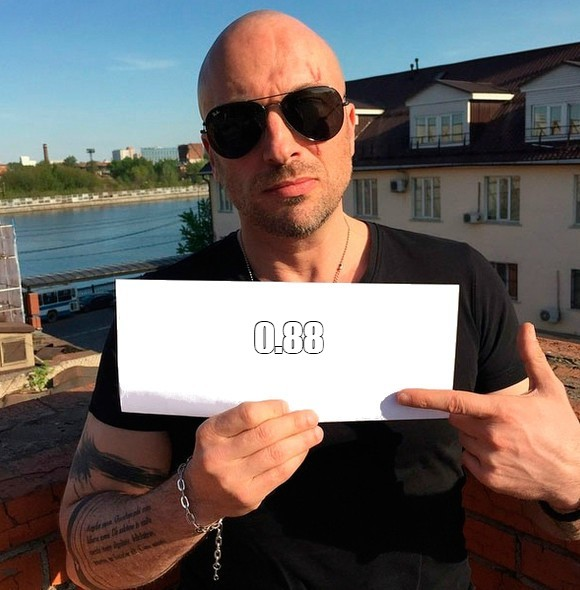